Follow the tutorial material from Kaggle (use TF-IDF instead)

In [1]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

# Read data

In [2]:
train = pd.read_csv('./data/labeledTrainData.tsv', delimiter='\t', quoting=3)
test = pd.read_csv('./data/testData.tsv', delimiter='\t', quoting=3)

# get the number of training and test examples
n_train = len(train)
n_test = len(test)

print('Training set shape\t', train.shape)
print('Testing set shape\t', test.shape)
print('Positive vs. Negative:\t', len(train[train['sentiment'] == 1]),\
      len(train[train['sentiment'] != 1]))

Training set shape	 (25000, 3)
Testing set shape	 (25000, 2)
Positive vs. Negative:	 12500 12500


In [3]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


# Data Cleaning and Processing

In [4]:
def review2words(review):
    """ function to convert input review into string of words """
    # Remove HTML
    review_text = BeautifulSoup(review, 'lxml').get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # Join the words and return the result.
    return " ".join(words)

In [5]:
# get train label
train_y = train['sentiment'].values

# transform reviews into words list
train_review = list(map(review2words, train['review']))
test_review = list(map(review2words, test['review']))

# combine train and test reviews
all_review = train_review + test_review

In [6]:
# perform TF-IDF transformation
vectorizer = TfidfVectorizer(min_df=3, analyzer="word", strip_accents='unicode', 
                             sublinear_tf=True, stop_words='english', 
                             max_features=5000, ngram_range=(1, 2)) 

# fit and transform the data
all_features = vectorizer.fit_transform(all_review)

# trainsform into array
train_features = all_features[:n_train, :].toarray()
test_features = all_features[n_train:, :].toarray()

# Logistic Regression with Ridge Penalty

In [7]:
# cross validation
logit2CV = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', scoring='roc_auc', 
                                solver='liblinear', tol=0.0001, max_iter=100, 
                                n_jobs=-1, refit=True,  random_state=2017)
logit2CV = logit2CV.fit(train_features, train_y)
logit2CV.C_

array([ 2.7825594])

In [8]:
# fit the Logistic model
logit2 = LogisticRegression(penalty='l2', tol=0.0001, C=2.7825549, random_state=2017, 
                            solver='liblinear', n_jobs=-1, verbose=0)
logit2 = logit2.fit(train_features, train_y)

In [9]:
# make predictions
train_pred = logit2.predict_proba(train_features)[:, 1]
test_pred = logit2.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/logit_ridge.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 0.9809314304


In [10]:
# find all the words used
words = vectorizer.get_feature_names()
logit2coef = logit2.coef_[0, :]

# sort to get the most positive and negative words
tmp = list(zip(logit2coef, words))
tmp.sort(reverse=False)
words_sorted = [word for (_, word) in tmp]

# choose the most positive and most negative words
print('Most negative words:\n', words_sorted[:10])
print('Most positive words:\n', words_sorted[-10:])

Most negative words:
 ['worst', 'awful', 'waste', 'bad', 'boring', 'disappointment', 'poorly', 'dull', 'poor', 'worse']
Most positive words:
 ['rare', 'today', 'enjoyable', 'amazing', 'favorite', 'best', 'wonderful', 'perfect', 'great', 'excellent']


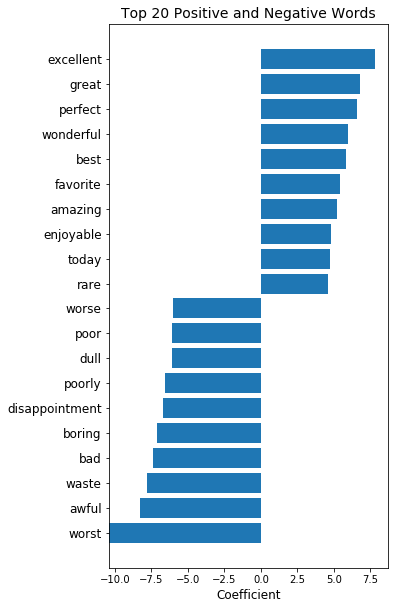

In [11]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
logit2coef = logit2.coef_[0, :]

# make importances relative to max importance
sorted_idx = np.argsort(logit2coef, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 10
idx = np.concatenate((sorted_idx[:N], sorted_idx[-N:]))

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:2 * N], logit2coef[idx], align='center')
plt.yticks(pos[: 2 * N], words[idx], fontsize=12)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top {0} Positive and Negative Words'.format(2 * N), fontsize=14)
plt.show()

# Logistic Regression with Lasso Penalty

In [12]:
# cross validation
logit1CV = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', scoring='roc_auc', 
                                solver='liblinear', tol=0.0001, max_iter=100, 
                                n_jobs=-1, refit=True,  random_state=2017)
logit1CV = logit1CV.fit(train_features, train_y)
logit1CV.C_

array([ 2.7825594])

In [13]:
# fit the Logistic model
logit1 = LogisticRegression(penalty='l1', tol=0.0001, C=2.7825549, random_state=2017, 
                            solver='liblinear', n_jobs=-1, verbose=0)
logit1 = logit1.fit(train_features, train_y)

In [14]:
# make predictions
train_pred = logit1.predict_proba(train_features)[:, 1]
test_pred = logit1.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/logit_lasso.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 0.9823521664


In [15]:
# find all the words used
words = vectorizer.get_feature_names()
logit1coef = logit1.coef_[0, :]

# sort to get the most positive and negative words
tmp = list(zip(logit1coef, words))
tmp.sort(reverse=False)
words_sorted = [word for (_, word) in tmp]

# choose the most positive and most negative words
print('Most negative words:\n', words_sorted[:10])
print('Most positive words:\n', words_sorted[-10:])

Most negative words:
 ['worst', 'waste', 'awful', 'poorly', 'disappointment', 'pointless', 'lacks', 'boring', 'forgettable', 'obnoxious']
Most positive words:
 ['wonderful', 'enjoyable', 'great job', 'captures', 'rare', 'vengeance', 'perfect', 'wonderfully', 'excellent', 'refreshing']


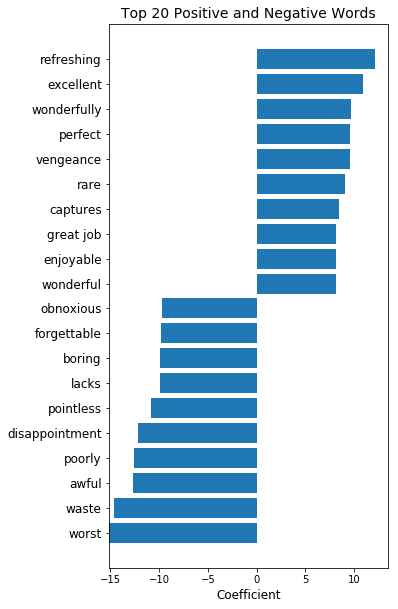

In [16]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
logit1coef = logit1.coef_[0, :]

# make importances relative to max importance
sorted_idx = np.argsort(logit1coef, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 10
idx = np.concatenate((sorted_idx[:N], sorted_idx[-N:]))

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:2 * N], logit1coef[idx], align='center')
plt.yticks(pos[: 2 * N], words[idx], fontsize=12)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top {0} Positive and Negative Words'.format(2 * N), fontsize=14)
plt.show()

# Multinomial Naive Bayes Model

In [18]:
# do cross validation
for alpha in [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    nb_cv = MultinomialNB(alpha=alpha, fit_prior=True, class_prior=None)
    scores = cross_val_score(nb_cv, train_features, train_y, cv=5, 
                             scoring='roc_auc')
    print(alpha, '\t', np.mean(scores))

0.01 	 0.931494912
0.1 	 0.931573056
0.5 	 0.931783936
1.0 	 0.931981504
2.0 	 0.93220464
5.0 	 0.93239744
10.0 	 0.932166496


In [19]:
# build the NB model
nb = MultinomialNB(alpha=5.0, fit_prior=True, class_prior=None)
nb = nb.fit(train_features, train_y)

In [20]:
# make predictions
train_pred = nb.predict_proba(train_features)[:, 1]
test_pred = nb.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/naive_bayes.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 0.9420629632


# Split into sub_train and sub_test for cross validation

In [21]:
# split into 75% training and 25% testing
x_train, x_test, y_train, y_test = \
    train_test_split(train_features, train_y, 
                     test_size=0.25, random_state=2017)

# AdaBoost

In [22]:
# build the AdaBoost classifier for cross validation
n_estimators = 500
adaboost_cv = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1.0, 
                                 algorithm='SAMME.R', random_state=2017)
adaboost_cv = adaboost_cv.fit(x_train, y_train)

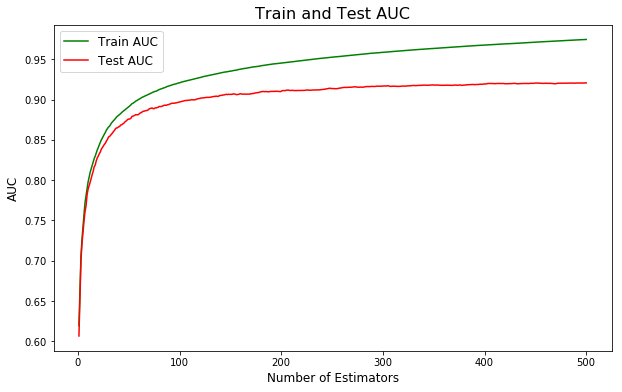

In [24]:
# calculate the change of training and test AUC
auc_train = np.zeros(n_estimators)
auc_test = np.zeros(n_estimators)

# training AUC
for i, y_pred in enumerate(adaboost_cv.staged_predict_proba(x_train)):
    auc_train[i] = roc_auc_score(y_train, y_pred[:, 1])
    
# test AUC
for i, y_pred in enumerate(adaboost_cv.staged_predict_proba(x_test)):
    auc_test[i] = roc_auc_score(y_test, y_pred[:, 1])

# plot of training and test AUC
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, n_estimators + 1), auc_train, 'g', label='Train AUC')
ax.plot(range(1, n_estimators + 1), auc_test, 'r', label='Test AUC')
ax.set_title('Train and Test AUC', fontsize=16)
ax.set_xlabel('Number of Estimators', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [25]:
# build the AdaBoost classifier
adaboost = AdaBoostClassifier(n_estimators=400, learning_rate=1.0, 
                              algorithm='SAMME.R', random_state=2017)
adaboost = adaboost.fit(train_features, train_y)

In [26]:
# make predictions
train_pred = adaboost.predict_proba(train_features)[:, 1]
test_pred = adaboost.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/adaboost.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 0.9616129664


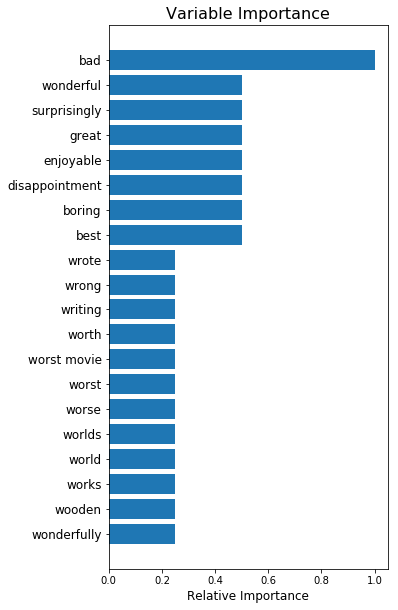

In [27]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
importance = adaboost.feature_importances_

# make importances relative to max importance
importance = importance / importance.max()
sorted_idx = np.argsort(importance, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 20
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:N], importance[sorted_idx[-N:]], align='center')
plt.yticks(pos[:N], words[sorted_idx[-N:]], fontsize=12)
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Variable Importance', fontsize=16)
plt.show()

# Gradient Boosting 

In [28]:
# build the Gradient Boosting classifier for cross validation
n_estimators = 500
gbm_cv = GradientBoostingClassifier(learning_rate=0.2, n_estimators=n_estimators, subsample=1.0,
                                    max_features='auto', min_samples_split=2, random_state=2017, 
                                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3)
gbm_cv = gbm_cv.fit(x_train, y_train)

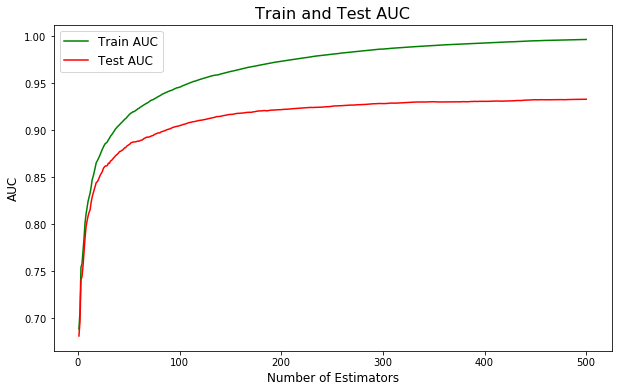

In [29]:
# calculate the change of training and test AUC
auc_train = np.zeros(n_estimators)
auc_test = np.zeros(n_estimators)

# training AUC
for i, y_pred in enumerate(gbm_cv.staged_predict_proba(x_train)):
    auc_train[i] = roc_auc_score(y_train, y_pred[:, 1])
    
# test AUC
for i, y_pred in enumerate(gbm_cv.staged_predict_proba(x_test)):
    auc_test[i] = roc_auc_score(y_test, y_pred[:, 1])

# plot of training and test AUC
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, n_estimators + 1), auc_train, 'g', label='Train AUC')
ax.plot(range(1, n_estimators + 1), auc_test, 'r', label='Test AUC')
ax.set_title('Train and Test AUC', fontsize=16)
ax.set_xlabel('Number of Estimators', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.legend(fontsize=12)
plt.show()

In [30]:
# build the Gradient Boosting classifier
gbm = GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, subsample=1.0,
                                 max_features='auto', min_samples_split=2, random_state=2017, 
                                 min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3)
gbm = gbm.fit(train_features, train_y)

In [31]:
# make predictions
train_pred = gbm.predict_proba(train_features)[:, 1]
test_pred = gbm.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/gbm.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 0.9919758208


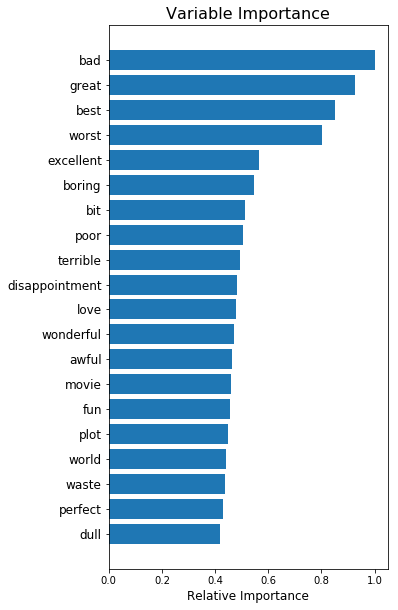

In [32]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
importance = gbm.feature_importances_

# make importances relative to max importance
importance = importance / importance.max()
sorted_idx = np.argsort(importance, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 20
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:N], importance[sorted_idx[-N:]], align='center')
plt.yticks(pos[:N], words[sorted_idx[-N:]], fontsize=12)
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Variable Importance', fontsize=16)
plt.show()

# Random Forest Model

In [7]:
# # exploratory study to determine the best number of estimators
# n_estimators = 500
# forest = RandomForestClassifier(warm_start=True, oob_score=True, random_state=2017, 
#                                 n_jobs=-1, max_features='auto')

# oob = []
# for i in range(1, n_estimators + 1):
#     forest.set_params(n_estimators=i)
#     forest = forest.fit(train_features, train_y)
#     oob.append(forest.oob_score_)

# # plot the curve of OOB error rate
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.plot(range(1, len(oob) + 1), 1 - np.array(oob), '-')
# ax.set_xlabel('N_estimator', fontsize=12)
# ax.set_ylabel('OOB Error Rate', fontsize=12)
# ax.set_title('OOB Error Rate vs. # Estimators')
# plt.show()

In [8]:
# Initialize a Random Forest classifier
forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=2017, 
                                oob_score=True, max_features='auto') 

# Fit the forest to the training set
forest = forest.fit(train_features, train_y)

In [9]:
# make predictions
train_pred = forest.predict_proba(train_features)[:, 1]
test_pred = forest.predict_proba(test_features)[:, 1]

# save prediction into local files
output = pd.DataFrame(data={"id": test["id"], "sentiment": test_pred})
output.to_csv("./result/random_forest.csv", index=False, quoting=3)

# get the AUC score
print('Training AUC\t', roc_auc_score(train_y, train_pred))

Training AUC	 1.0


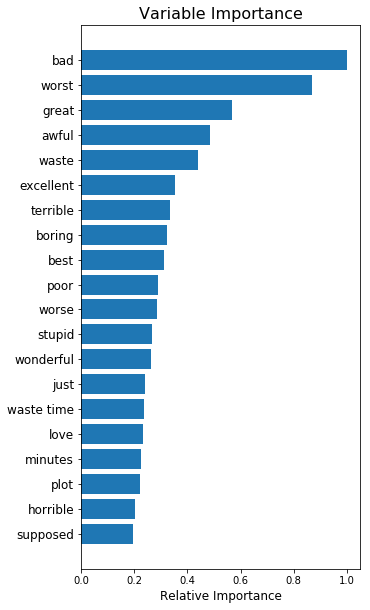

In [10]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
importance = forest.feature_importances_

# make importances relative to max importance
importance = importance / importance.max()
sorted_idx = np.argsort(importance, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 20
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:N], importance[sorted_idx[-N:]], align='center')
plt.yticks(pos[:N], words[sorted_idx[-N:]], fontsize=12)
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Variable Importance', fontsize=16)
plt.show()

# XGBoost